# 目标检测和边界框
在前面的一些章节中，我们介绍了诸多用于图像分类的模型。在图像分类任务里，我们假设图像里只有一个主体目标，并关注如何识别该目标的类别。然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉里，我们将这类任务称为目标检测（object detection）或物体检测。

目标检测在多个领域中被广泛使用。例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍的位置来规划行进线路。机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

In [1]:
%matplotlib inline
from PIL import Image

import sys
sys.path.append("..") 
import dl_utils

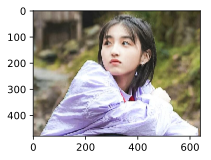

In [12]:
dl_utils.set_figsize((3,6))
zzfimg = Image.open('imgs/zzf.jpg')
dl_utils.plt.imshow(zzfimg);

## 不好意思搞错了
应该是这个

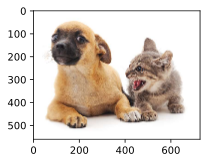

In [6]:
dl_utils.set_figsize((3,6))
img = Image.open('imgs/catdog.jpg')
dl_utils.plt.imshow(img);

## 边界框
在目标检测里，我们通常使用边界框（bounding box）来描述目标位置。边界框是一个矩形框，可以由矩形左上角的$x$和$y$轴坐标与右下角的$x$和$y$轴坐标确定。我们根据上面的图的坐标信息来定义图中狗和猫的边界框。图中的坐标原点在图像的左上角，原点往右和往下分别为$x$轴和$y$轴的正方向。

In [7]:
# bbox是bounding box的缩写
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

我们可以在图中将边界框画出来，以检查其是否准确。画之前，我们定义一个辅助函数bbox_to_rect。它将边界框表示成matplotlib的边界框格式。

In [8]:
def bbox_to_rect(bbox, color):  # 本函数已保存在d2lzh_pytorch中方便以后使用
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return dl_utils.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

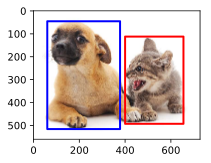

In [10]:
#我们将边界框加载在图像上，可以看到目标的主要轮廓基本在框内。

fig = dl_utils.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 在目标检测里不仅需要找出图像里面所有感兴趣的目标，而且要知道它们的位置。位置一般由矩形边界框来表示。

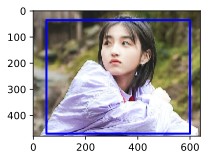

In [15]:
fig = dl_utils.plt.imshow(zzfimg)
zzf_bbox = [50,35,600,470]
fig.axes.add_patch(bbox_to_rect(zzf_bbox, 'blue'))

# 锚框 Anchor
目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的真实边界框（ground-truth bounding box）。不同的模型使用的区域采样方法可能不同。这里我们介绍其中的一种方法：**它以每个像素为中心** 生成**多个大小和宽高比（aspect ratio）不同的边界框**。这些边界框被称为**锚框（anchor box）**。我们将在后面基于锚框实践目标检测。



### 每个像素为中心，生成若干宽高比的锚框 生成多个锚框

假设输入图像高为$h$，宽为$w$。我们分别以图像的每个像素为中心生成不同形状的锚框。设大小为$s\in (0,1]$且宽高比为$r > 0$，那么锚框的宽和高将分别为$ws\sqrt{r}$和$hs/\sqrt{r}$。当中心位置给定时，已知宽和高的锚框是确定的。

下面我们分别设定好一组大小$s_1,\ldots,s_n$和一组宽高比$r_1,\ldots,r_m$。如果以每个像素为中心时使用所有的大小与宽高比的组合，输入图像将一共得到$whnm$个锚框。虽然这些锚框可能覆盖了所有的真实边界框，但计算复杂度容易过高。因此，我们通常只对包含$s_1$或$r_1$的大小与宽高比的组合感兴趣，即

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$

也就是说，以相同像素为中心的锚框的数量为$n+m-1$。对于整个输入图像，我们将一共生成$wh(n+m-1)$个锚框。

以上生成锚框的方法实现在下面的MultiBoxPrior函数中。指定输入、一组大小和一组宽高比，该函数将返回输入的所有锚框。

注: PyTorch官方在torchvision.models.detection.rpn里有一个AnchorGenerator类可以用来生成anchor，但是和这里讲的不一样，感兴趣的可以去看看。

In [32]:
dl_utils.set_figsize()
img = Image.open('imgs/catdog.jpg')
w, h = img.size
import torch
import math
import numpy as np
print("w = %d, h = %d" % (w, h)) # w = 728, h = 561
# 本函数已保存在d2lzh_pytorch包中方便以后使用
# size 是归一化大小， 例如size = 0.5 对应面积为 0.5*0.5, 比例为1的的bbox
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) of generated MultiBoxPriores. 
        ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
    Returns:
        anchors of shape (1, num_anchors, 4). 由于batch里每个都一样, 所以第一维为1
    """
    #全部覆盖复杂度高，只覆盖部分大小和宽高比。
    pairs = [] # pair of (size, sqrt(ration))
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])
    
    pairs = np.array(pairs)
    print(pairs)
    
    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ration)
    print(ss1,ss2)
    print(np.sqrt(ss1*ss2))
    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2
    
    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    
    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))
    
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)


X = torch.Tensor(1, 3, h, w)  # 构造输入数据
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape # torch.Size([1, 2042040, 4])

w = 728, h = 561
[[0.75       1.        ]
 [0.75       1.41421356]
 [0.75       0.70710678]
 [0.5        1.        ]
 [0.25       1.        ]]
[0.75       1.06066017 0.53033009 0.5        0.25      ] [0.75       0.53033009 1.06066017 0.5        0.25      ]
[0.75 0.75 0.75 0.5  0.25]


torch.Size([1, 2042040, 4])

我们看到，返回锚框变量y的形状为（1，锚框个数，4）。将锚框变量y的形状变为（图像高，图像宽，以相同像素为中心的锚框个数，4）后，我们就可以通过指定像素位置来获取所有以该像素为中心的锚框了。下面的例子里我们访问以（250，250）为中心的第一个锚框。它有4个元素，分别是锚框左上角的$x$和$y$轴坐标和右下角的$x$和$y$轴坐标，其中$x$和$y$轴的坐标值分别已除以图像的宽和高，因此值域均为0和1之间。

In [33]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]# * torch.tensor([w, h, w, h], dtype=torch.float32)

tensor([-0.0316,  0.0706,  0.7184,  0.8206])

可以验证一下以上输出对不对：size和ratio分别为0.75和1, 则(归一化后的)宽高均为0.75, 所以输出是正确的（0.75 = 0.7184 + 0.0316 = 0.8206 - 0.0706）。

In [34]:
#为了描绘图像中以某个像素为中心的所有锚框，我们先定义show_bboxes函数以便在图像上画出多个边界框。

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = dl_utils.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

刚刚我们看到，变量boxes中$x$和$y$轴的坐标值分别已除以图像的宽和高。在绘图时，我们需要恢复锚框的原始坐标值，并因此定义了变量bbox_scale。现在，我们可以画出图像中以(250, 250)为中心的所有锚框了。可以看到，大小为0.75且宽高比为1的锚框较好地覆盖了图像中的狗。

In [37]:
from imp import reload
reload(dl_utils)

<module 'dl_utils' from '..\\dl_utils.py'>

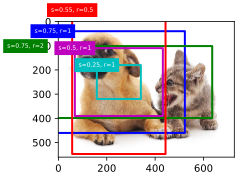

In [38]:
dl_utils.set_figsize()
fig = dl_utils.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.75, r=2', 's=0.55, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])


In [40]:
boxes[250, 250, :, :].shape

torch.Size([5, 4])

 ## 交并比
我们刚刚提到某个锚框较好地覆盖了图像中的狗。如果该目标的真实边界框已知，这里的“较好”该如何量化呢？一种直观的方法是衡量锚框和真实边界框之间的相似度。我们知道，Jaccard系数（Jaccard index）可以衡量两个集合的相似度。给定集合$\mathcal{A}$和$\mathcal{B}$，它们的Jaccard系数即二者交集大小除以二者并集大小：

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

实际上，我们可以把边界框内的像素区域看成是像素的集合。如此一来，我们可以用两个边界框的像素集合的Jaccard系数衡量这两个边界框的相似度。当衡量两个边界框的相似度时，我们通常将Jaccard系数称为交并比（Intersection over Union，IoU），即两个边界框相交面积与相并面积之比，如图9.2所示。交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框相等。
<div align=center>
<img width="400" src="imgs/9.4_iou.svg"/>
</div>
<div align=center> 交并比是两个边界框相交面积与相并面积之比</div>
![]()

In [41]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
# 参考https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py#L356
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

## 标注训练集的锚框
在训练集中，我们将每个锚框视为一个训练样本。为了训练**目标检测模型**，我们需要为**每个锚框标注两类标签**：一是锚框所含**目标的类别，简称类别**；二是**真实边界框相对锚框的偏移量，简称偏移量（offset）**。在目标检测时，我们首先**生成多个锚框**，然后为每个锚框**预测类别以及偏移量**，接着根据**预测的偏移量调整锚框位置**从而得到预测边界框，最后筛选需要输出的预测边界框。

我们知道，在目标检测的训练集中，每个图像已标注了**真实边界框的位置**以及所含**目标的类别**。在生成锚框之后，我们主要依据与锚框相似的真实边界框的位置和类别信息为锚框标注。那么，该如何为锚框分配与其相似的真实边界框呢？

假设图像中锚框分别为$A_1, A_2, \ldots, A_{n_a}$，真实边界框分别为$B_1, B_2, \ldots, B_{n_b}$，且$n_a \geq n_b$。定义矩阵$\boldsymbol{X} \in \mathbb{R}^{n_a \times n_b}$，其中第$i$行第$j$列的元素$x_{ij}$为锚框$A_i$与真实边界框$B_j$的交并比。 首先，我们找出矩阵$\boldsymbol{X}$中最大元素，并将该元素的行索引与列索引分别记为$i_1,j_1$。我们为锚框$A_{i_1}$分配真实边界框$B_{j_1}$。显然，锚框$A_{i_1}$和真实边界框$B_{j_1}$在所有的“锚框—真实边界框”的配对中相似度最高。接下来，将矩阵$\boldsymbol{X}$中第$i_1$行和第$j_1$列上的所有元素丢弃。找出矩阵$\boldsymbol{X}$中剩余的最大元素，并将该元素的行索引与列索引分别记为$i_2,j_2$。我们为锚框$A_{i_2}$分配真实边界框$B_{j_2}$，再将矩阵$\boldsymbol{X}$中第$i_2$行和第$j_2$列上的所有元素丢弃。此时矩阵$\boldsymbol{X}$中已有两行两列的元素被丢弃。 依此类推，直到矩阵$\boldsymbol{X}$中所有$n_b$列元素全部被丢弃。这个时候，我们已为$n_b$个锚框各分配了一个真实边界框。 接下来，我们只遍历剩余的$n_a - n_b$个锚框：给定其中的锚框$A_i$，根据矩阵$\boldsymbol{X}$的第$i$行找到与$A_i$交并比最大的真实边界框$B_j$，且只有当该交并比大于预先设定的阈值时，才为锚框$A_i$分配真实边界框$B_j$。

如图9.3（左）所示，假设矩阵$\boldsymbol{X}$中最大值为$x_{23}$，我们将为锚框$A_2$分配真实边界框$B_3$。然后，丢弃矩阵中第2行和第3列的所有元素，找出剩余阴影部分的最大元素$x_{71}$，为锚框$A_7$分配真实边界框$B_1$。接着如图9.3（中）所示，丢弃矩阵中第7行和第1列的所有元素，找出剩余阴影部分的最大元素$x_{54}$，为锚框$A_5$分配真实边界框$B_4$。最后如图9.3（右）所示，丢弃矩阵中第5行和第4列的所有元素，找出剩余阴影部分的最大元素$x_{92}$，为锚框$A_9$分配真实边界框$B_2$。之后，我们只需遍历除去$A_2, A_5, A_7, A_9$的剩余锚框，并根据阈值判断是否为剩余锚框分配真实边界框。
<div align=center>
<img width="400" src="imgs/9.4_anchor-label.svg"/>
</div>
<div align=center> 锚框分配真实边界框</div>
现在我们可以标注锚框的类别和偏移量了。如果一个锚框$A$被分配了真实边界框$B$，将锚框$A$的类别设为$B$的类别，并根据$B$和$A$的中心坐标的相对位置以及两个框的相对大小为锚框$A$标注偏移量。由于数据集中各个框的位置和大小各异，因此这些相对位置和相对大小通常需要一些特殊变换，才能使偏移量的分布更均匀从而更容易拟合。设锚框$A$及其被分配的真实边界框$B$的中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，$A$和$B$的宽分别为$w_a$和$w_b$，高分别为$h_a$和$h_b$，一个常用的技巧是将$A$的偏移量标注为

$$ \left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x}, \frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y}, \frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w}, \frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right), $$

其中常数的默认值为$\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1, \sigma_w=\sigma_h=0.2$。如果一个锚框没有被分配真实边界框，我们只需将该锚框的类别设为背景。类别为背景的锚框通常被称为负类锚框，其余则被称为正类锚框。

下面演示一个具体的例子。我们为读取的图像中的猫和狗定义真实边界框，其中第一个元素为类别（0为狗，1为猫），剩余4个元素分别为左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。这里通过左上角和右下角的坐标构造了5个需要标注的锚框，分别记为$A_0, \ldots, A_4$（程序中索引从0开始）。先画出这些锚框与真实边界框在图像中的位置。


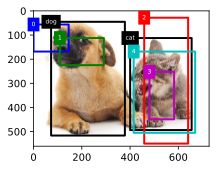

In [42]:
bbox_scale = torch.tensor((w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = dl_utils.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

下面实现MultiBoxTarget函数来为锚框标注类别和偏移量。该函数将背景类别设为0，并令从零开始的目标类别的整数索引自加1（1为狗，2为猫）。

In [43]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「9.4.1. 生成多个锚框」图9.3所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 初始全为-1
    
    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行
     
    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j
    
    return torch.tensor(assigned_idx, dtype=torch.long)

def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]
    
    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]

        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels
    
    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)
    
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    
    return [bbox_offset, bbox_mask, cls_labels]

In [44]:
#我们通过unsqueeze函数为锚框和真实边界框添加样本维。

labels = MultiBoxTarget(anchors.unsqueeze(dim=0),
                        ground_truth.unsqueeze(dim=0))

In [45]:
labels[2] 

tensor([[0, 1, 2, 0, 2]])

In [46]:
labels
#为锚框进行标注， 类别和偏移量， 还有mask 掩码变量中的0可以在计算目标函数之前过滤掉负类的偏移量。

[tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
           1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
           1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]])]

我们根据锚框与真实边界框在图像中的位置来分析这些标注的类别。首先，在所有的“锚框—真实边界框”的配对中，锚框$A_4$与猫的真实边界框的交并比最大，因此锚框$A_4$的类别标注为猫。不考虑锚框$A_4$或猫的真实边界框，在剩余的“锚框—真实边界框”的配对中，最大交并比的配对为锚框$A_1$和狗的真实边界框，因此锚框$A_1$的类别标注为狗。接下来遍历未标注的剩余3个锚框：与锚框$A_0$交并比最大的真实边界框的类别为狗，但交并比小于阈值（默认为0.5），因此类别标注为背景；与锚框$A_2$交并比最大的真实边界框的类别为猫，且交并比大于阈值，因此类别标注为猫；与锚框$A_3$交并比最大的真实边界框的类别为猫，但交并比小于阈值，因此类别标注为背景。

返回值的第二项为掩码（mask）变量，形状为(批量大小, 锚框个数的四倍)。掩码变量中的元素与每个锚框的4个偏移量一一对应。 由于我们不关心对背景的检测，有关负类的偏移量不应影响目标函数。通过按元素乘法，掩码变量中的0可以在计算目标函数之前过滤掉负类的偏移量。

In [47]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [48]:
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

## 输出预测边界框
在模型预测阶段，我们先为图像生成多个锚框，并为这些锚框一一预测类别和偏移量。随后，我们根据锚框及其预测偏移量得到预测边界框。当锚框数量较多时，同一个目标上可能会输出较多相似的预测边界框。为了使结果更加简洁，我们可以移除相似的预测边界框。常用的方法叫作非极大值抑制（non-maximum suppression，NMS）。

我们来描述一下非极大值抑制的工作原理。对于一个预测边界框$B$，模型会计算各个类别的预测概率。设其中最大的预测概率为$p$，该概率所对应的类别即$B$的预测类别。我们也将$p$称为预测边界框$B$的置信度。在同一图像上，我们将预测类别非背景的预测边界框按置信度从高到低排序，得到列表$L$。从$L$中选取置信度最高的预测边界框$B_1$作为基准，将所有与$B_1$的交并比大于某阈值的非基准预测边界框从$L$中移除。这里的阈值是预先设定的超参数。此时，$L$保留了置信度最高的预测边界框并移除了与其相似的其他预测边界框。 接下来，从$L$中选取置信度第二高的预测边界框$B_2$作为基准，将所有与$B_2$的交并比大于某阈值的非基准预测边界框从$L$中移除。重复这一过程，直到$L$中所有的预测边界框都曾作为基准。此时$L$中任意一对预测边界框的交并比都小于阈值。最终，输出列表$L$中的所有预测边界框。

下面来看一个具体的例子。先构造4个锚框。简单起见，我们假设预测偏移量全是0：预测边界框即锚框。最后，我们构造每个类别的预测概率。

In [50]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0.0] * (4 * len(anchors)))
cls_probs = torch.tensor([[0., 0., 0., 0.,],  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

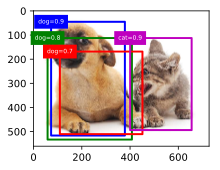

In [52]:
fig = dl_utils.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [53]:
offset_preds

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
from collections import namedtuple
Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])

def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)

    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)
        
        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
        
        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )
        
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]
    
    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量
        
        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        
        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]
        
        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]
        
        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])
            
        return torch.tensor(output) # shape: (锚框个数, 6)
    
    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
    
    return torch.stack(batch_output)

然后我们运行MultiBoxDetection函数并设阈值为0.5。这里为输入都增加了样本维。我们看到，返回的结果的形状为(批量大小, 锚框个数, 6)。其中每一行的6个元素代表同一个预测边界框的输出信息。第一个元素是索引从0开始计数的预测类别（0为狗，1为猫），其中-1表示背景或在非极大值抑制中被移除。第二个元素是预测边界框的置信度。剩余的4个元素分别是预测边界框左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。

In [60]:
output = MultiBoxDetection(
    cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0), nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800]]])

我们移除掉类别为-1的预测边界框，并可视化非极大值抑制保留的结果。

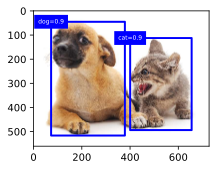

In [61]:
fig = dl_utils.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，我们可以在执行非极大值抑制前**将置信度较低的预测边界框移除**，从而减小非极大值抑制的计算量。我们还可以筛选非极大值抑制的输出，例如，只保留其中置信度较高的结果作为最终输出。

## 小结
以每个像素为中心，生成多个大小和宽高比不同的锚框。
交并比是两个边界框相交面积与相并面积之比。
在训练集中，为每个锚框标注两类标签：一是锚框所含目标的类别；二是真实边界框相对锚框的偏移量。
预测时，可以使用非极大值抑制来移除相似的预测边界框，从而令结果简洁。